## Imports
utilities.py contains a number of useful functions including loading credentials from a json file, retrieving files from S3, and defining thecurrent list of brains that are associated with the Active Atlas.

In [34]:
import datajoint as dj
import numpy as np
import json
from subprocess import call
import yaml
import sys, os

sys.path.append('./lib')
from utilities import *
from initialization_of_db import *

## Load Credentials, Connect to Database
User must specify their own filepath to their aws S3 credentials and Datajoint credentials in json format.

In [3]:
%%writefile setup/credFiles.yaml
aws_fp: /mnt/c/Users/Alex/Documents/json_credentials/alex_aws_credentials.json
dj_fp: /mnt/c/Users/Alex/Documents/json_credentials/datajoint_db_credentials.json

Overwriting credFiles.yaml


In [25]:
# Load Datajoint Credentials
# `dj_creds` needs the following fields: 'user', 'passwd'
dj_creds = get_dj_creds()

In [27]:
dj.config['database.user'] = dj_creds['user']
dj.config['database.password'] = dj_creds['passwd']
dj.config['database.host'] =  dj_creds['host']
dj.config['database.port'] = dj_creds['port']
dj.config.save_local()

# Connect to datajoint server
dj.conn()

DataJoint connection (connected) dbadmin@ucsd-demo-db.datajoint.io:3306

In [28]:
# Define which schema you're using
schema = dj.schema('common_atlas_v3')
schema.spawn_missing_classes()

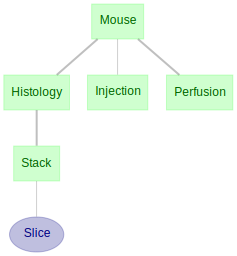

In [29]:
dj.ERD(schema)

In [31]:
print('________ Mouse ________')
Mouse.describe()
print('________ Histology ________')
Histology.describe()
print('________ Stack ________')
Stack.describe()
print('________ Slice ________')
Slice.describe()

________ Mouse ________
mouse                : char(18)                     # Name for lab mouse, max 8 chars
---
date_of_birth        : date                         # (date) the mouse's date of birth
sex                  : enum('M','F')                # (M/F) either 'M' for male, 'F' for female
genotype             : varchar(10)                  # (Str) indicating the genotype
weight               : double                       # (int) weight of the mouse in grams. -1 if unknown
bred                 : varchar(20)                  # (Str) Vendor where the mouse was bred (bred in house, purchased by vendor)

________ Histology ________
-> Mouse
---
region               : varchar(10)                  # (Str) [UNSURE]
thickness            : int                          # (int) thickness of each slice in microns
orientation          : enum('sagittal','coronal','horozontal') # (Str) horizontal, sagittal, coronal
counter_stain        : varchar(30)                  # (Str) what stain was used

'-> Stack\nslice_num            : int                          # (int) the unique index of the brain slice. Thickness found in Histology table\n---\nslice_name           : varchar(100)                 # (str) the name of the slice. Naming scheme may vary from lab to lab\nvalid                : tinyint                      # (bool) if false, the slice does not exist\nraw_s3_fp            : varchar(200)                 # (str)\nprocessed_s3_fp      : varchar(200)                 # (str)\n'

## Printing all table headers (every stack in the db)

In [35]:
brainStackTables = (Stack()).fetch( as_dict=True )
for brainStackTable in brainStackTables:
    print( brainStackTable['mouse'] )

CHATM2
CHATM3
CSHL2
MD175
MD585
MD589
MD590
MD591
MD592
MD593
MD594
MD595
MD598
MD599
MD602
MD603
MD635
MD636
MD639
MD642
MD652
MD653
MD657
MD658
MD661
MD662
UCSD001


## List relevant info for given stack
#### - Example displaying MD585 sections


In [37]:
stack = 'MD585'

MD585_stack_info = (Stack()&dict(mouse=stack)).fetch( as_dict=True )[0]
print( 'Keys for <STACK>_stack_info:')
print( MD585_stack_info.keys() )
print('')

print('Section thickness:')
print( MD585_stack_info['section_thickness_um'] )
print('Channels (more than 1 means multiple stains):')
print( MD585_stack_info['channels'] )

Keys for <STACK>_stack_info:
odict_keys(['mouse', 'stack_name', 'num_slices', 'num_valid_slices', 'channels', 'sorted_filenames', 'human_annotated', 'planar_resolution_um', 'section_thickness_um'])

Section thickness:
20.0
Channels (more than 1 means multiple stains):
1


In [38]:
MD585_histology_info = (Histology()&dict(mouse=stack)).fetch( as_dict=True )[0]
print( 'Keys for <STACK>_histology_info:')
print( MD585_histology_info.keys() )
print('')

print('Stain used:')
print( MD585_histology_info['counter_stain'] )

Keys for <STACK>_histology_info:
odict_keys(['mouse', 'region', 'thickness', 'orientation', 'counter_stain', 'lab', 'series'])

Stain used:
thionin


## Access Raw & Processed Data
#### - Example accessing MD585 data

In [40]:
# Gives a List of Dictionaries. Each element in the list is a new slice.
MD585_slices = (Slice()&dict(mouse=stack)).fetch( as_dict=True )
print(MD585_slices[0].keys())

for slice in MD585_slices:
    print(slice['slice_num'])
    print(slice['slice_name'])
    # 'valid' equals 1 if the slice is valid, 0 otherwise
    print(slice['valid']==1)
    # Notice how NOT ALL SLICES have processed images. 'Processed' images only span the brainstem region.
    print(slice['processed_s3_fp'])
    print('')

odict_keys(['mouse', 'slice_num', 'slice_name', 'valid', 'raw_s3_fp', 'processed_s3_fp'])
1
Placeholder
False


2
Placeholder
False


3
MD585-N3-2015.07.16-19.48.34_MD585_1_0007
True


4
MD585-IHC3-2015.07.16-15.26.44_MD585_1_0007
True


5
MD585-N3-2015.07.16-19.48.34_MD585_2_0008
True


6
MD585-IHC3-2015.07.16-15.26.44_MD585_2_0008
True


7
MD585-N4-2015.07.16-19.50.10_MD585_1_0010
True


8
Placeholder
False


9
MD585-N4-2015.07.16-19.50.10_MD585_2_0011
True


10
MD585-IHC4-2015.07.18-07.01.12_MD585_1_0010
True


11
MD585-N4-2015.07.16-19.50.10_MD585_3_0012
True


12
MD585-IHC4-2015.07.18-07.01.12_MD585_2_0011
True


13
MD585-N5-2015.07.16-19.53.21_MD585_1_0013
True


14
MD585-IHC5-2015.07.18-07.03.14_MD585_1_0013
True


15
MD585-N5-2015.07.16-19.53.21_MD585_2_0014
True


16
MD585-IHC5-2015.07.18-07.03.14_MD585_2_0014
True


17
MD585-N5-2015.07.16-19.53.21_MD585_3_0015
True


18
MD585-IHC5-2015.07.18-07.03.14_MD585_3_0015
True


19
MD585-N6-2015.07.16-19.56.32_MD585_1_0016
True


20
M

In [41]:
slice_index = 200

print('RAW S3 location:')
print( MD585_slices[slice_index]['raw_s3_fp'] )
print('Processed S3 location:')
print( MD585_slices[slice_index]['processed_s3_fp'] )

RAW S3 location:
CSHL_data/MD585/MD585-N36-2015.07.16-21.53.31_MD585_2_0107_lossless.jp2
Processed S3 location:
CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-N36-2015.07.16-21.53.31_MD585_2_0107_prep2_lossless.tif


# Download Images from S3 to Local Computer
(Relies on `bucket` and `filename_list` from previous cell)

In [45]:
from subprocess import call

# S3 bucket must be appended to the s3_fp
def download_from_s3(s3_fp, local_root=os.environ['DWNLD_ROOT_DIR'], raw=False):
    if raw:
        s3_url = "s3://"+os.environ['BUCKET_RAWDATA']+"/" + s3_fp
    else:
        s3_url = "s3://"+os.environ['BUCKET_DATA']+"/" + s3_fp
    local_download_fp = local_root + s3_fp
    
    print("aws "+"s3 "+"cp "+s3_url+' '+local_download_fp)

    call(["aws",\
          "s3",\
          "cp",\
          s3_url,\
          local_download_fp])


In [46]:
# DOWNLOAD PROCESSED FILE
MD585_slice_200 =  MD585_slices[200]
s3_fp = MD585_slice_200['processed_s3_fp'] 

# Downloads to `DWNLD_ROOT_DIR` set in setup/config.sh by default
download_from_s3( s3_fp, raw=False)

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-N36-2015.07.16-21.53.31_MD585_2_0107_prep2_lossless.tif /mnt/c/Users/Alex/Documents/Atlas_Files/CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-N36-2015.07.16-21.53.31_MD585_2_0107_prep2_lossless.tif


In [48]:
# DOWNLOAD RAW FILE
MD585_slice_200 =  MD585_slices[200]
s3_fp = MD585_slice_200['raw_s3_fp'] 

# Downloads to `DWNLD_ROOT_DIR` set in setup/config.sh by default
download_from_s3( s3_fp, raw=True)

aws s3 cp s3://mousebrainatlas-rawdata-backup/CSHL_data/MD585/MD585-N36-2015.07.16-21.53.31_MD585_2_0107_lossless.jp2 /mnt/c/Users/Alex/Documents/Atlas_Files/CSHL_data/MD585/MD585-N36-2015.07.16-21.53.31_MD585_2_0107_lossless.jp2
